# Amazon Alexa Review - Sentiment Analysis


Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfe1cob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

In [5]:
# Load the data

data = pd.read_csv('Data/amazon_alexa.tsv',delimiter='\t')

data.shape

(3150, 5)

In [8]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [10]:
data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## In data analysis things we need to do
1.Missing values
2.Explore about the numeric variables
3.Explore about catgorical variables
4.Finding relationship between features

In [11]:
#Summ of null values in each columns
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [12]:
#GETTing the record of 'verified_reviws' that is null
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [13]:
#dropping the null records
data.dropna(inplace=True)

In [15]:
#Shape od dataset after droping
data.shape

(3149, 5)

In [23]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column
data['length'] = data['verified_reviews'].apply(len)

In [24]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [25]:
#Randomly check for 10Th record

print(f"'verified review' column value: {data.iloc[10]['verified_reviews']}")
print(f"length of the review: {len(data.iloc[10]['verified_reviews'])}")
print(f"length fro the colum 'length': {data.iloc[10]['length']}")

'verified review' column value: I sent it to my 85 year old Dad, and he talks to it constantly.
length of the review: 63
length fro the colum 'length': 63


In [26]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

## Analysing the 'rating' column

In [30]:
#distint values count for each ratings 

data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

#### Observation

most of the ratings belongs to '5"

so we take "5" and "4" and "3" as positive reviews and "1 and 2" as negative .
is there are many rating in "3" we could take that as neutral sinmce the data is very less moving those into positive

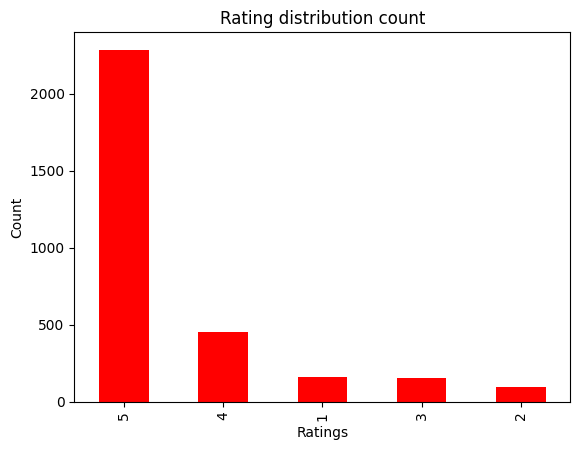

In [31]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color='red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [42]:
#Finding the percentage distribution of each rating - we'll divide the number of records

pecent_rating = round(data['rating'].value_counts()/data.shape[0]*100,2).to_dict()

In [44]:
pecent_rating

{5: 72.59, 4: 14.45, 1: 5.11, 3: 4.83, 2: 3.02}

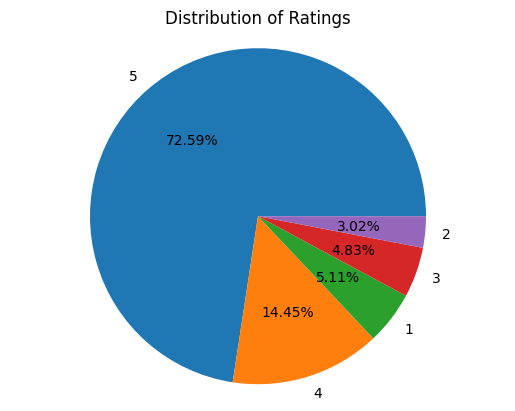

In [51]:
plt.pie(pecent_rating.values(),labels=pecent_rating.keys(),autopct='%1.2f%%',radius=2)

# Adding a title to the pie chart
plt.title('Distribution of Ratings')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
# Save the plot as a PNG file
plt.savefig('pie_chart.png')

# Show plot (optional)
plt.show()

## Analyzing 'feedback' column
This column refers to the feedback of the verified review

In [53]:
#Distinct values of 'feedback' and its count 
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [71]:
#Extracting the 'verified_reviews' and rating value for one record with feedback = 0
feedback_0 = data[data['feedback'] == 0].iloc[0]  # Get the first row where 'feedback' is 0
verified_reviews = feedback_0['verified_reviews']
rating = feedback_0['rating']

print(f" Rating: {rating}")
print(f"Verified Reviews: {verified_reviews}")


 Rating: 2
Verified Reviews: It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals.


In [64]:
#Extracting the 'verified_reviews' value for one record with feedback = 1
feedback_1 = data[data['feedback'] == 1].iloc[0]  # Get the first row where 'feedback' is 0
verified_reviews = feedback_1['verified_reviews']
rating = feedback_1['rating']

print(f" Rating: {rating}")
print(f"Verified Reviews: {verified_reviews}")

 Rating: 5
Verified Reviews: Love my Echo!


### Feedback refers to postive and neagtive feedback of customers

the sume of the rating 5,4,3 == count of positive feedback

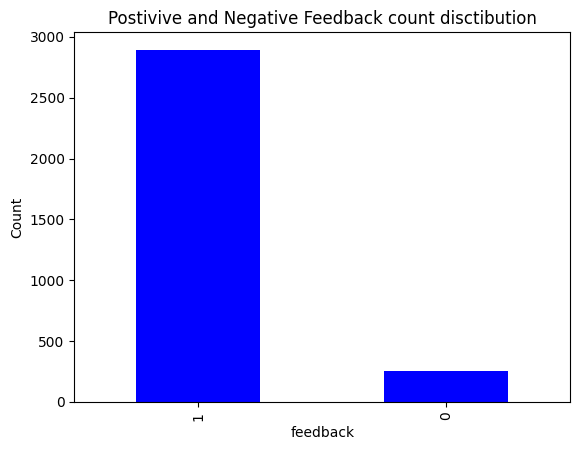

In [66]:
#Bar plot to visualize the total counts of each rating

data['feedback'].value_counts().plot.bar(color='blue')
plt.title('Postivive and Negative Feedback count disctibution')
plt.xlabel('feedback')
plt.ylabel('Count')
plt.show()

In [68]:
#Finding the percentage distribution of each feedback - we'll divide the number of record
feedback_percent =  round(data['feedback'].value_counts()/data.shape[0]*100,2).to_dict()

In [69]:
feedback_percent

{1: 91.87, 0: 8.13}

#### Feedback distribution

91.87% reviews are positive
8.13% reviews are negative

([<matplotlib.patches.Wedge at 0x7fd2453eb670>,
 [Text(-2.128630790880782, 0.555815577430371, '1'),
  Text(2.12863085592978, -0.5558153283093688, '0')],
 [Text(-1.1610713404804265, 0.3031721331438387, '91.87%'),
  Text(1.1610713759616982, -0.30317199725965566, '8.13%')])

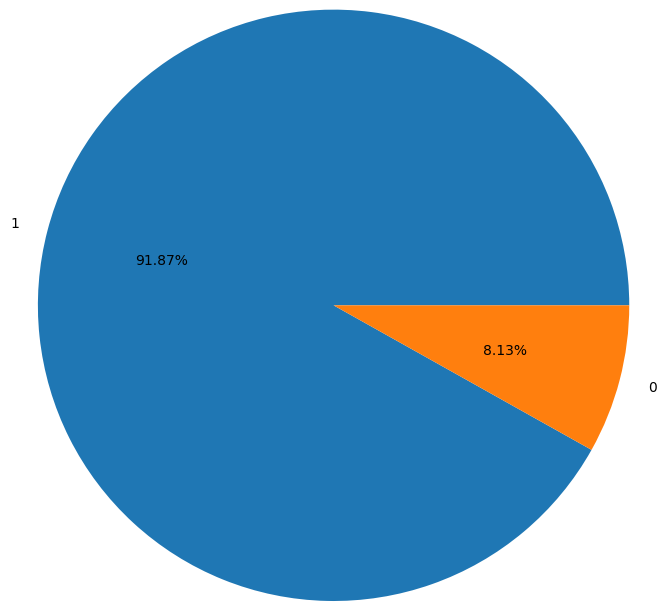

In [70]:
plt.pie(feedback_percent.values(),labels=feedback_percent.keys(),autopct='%1.2f%%',radius=2,shadow=True)

# Adding a title to the pie chart
plt.title('Distribution of feedback')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
# Save the plot as a PNG file
plt.savefig('pie_chart.png')

# Show plot (optional)
plt.show()

In [74]:
#feedback_0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [75]:
#feedback_1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

#### OBSERVATION :

If rating of a reviewer is 1 0r 2 --> feedback is 0 ( negative ) <br>
if rating of a reviewer is 3,4 and 5 --> feedback is 1 ( positive ) <br>


## Analysing 'variation' column

In [77]:
#Distinct values of 'variation' and its count 

data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

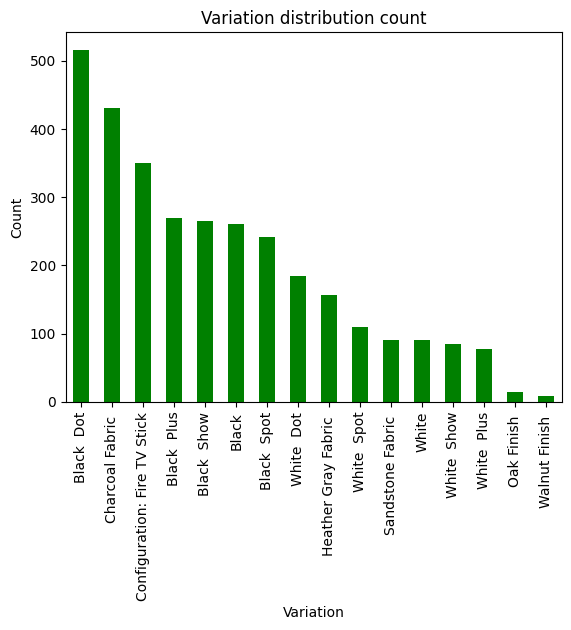

In [78]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color='green')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [80]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

round(data['variation'].value_counts()/data.shape[0]*100,2)


variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

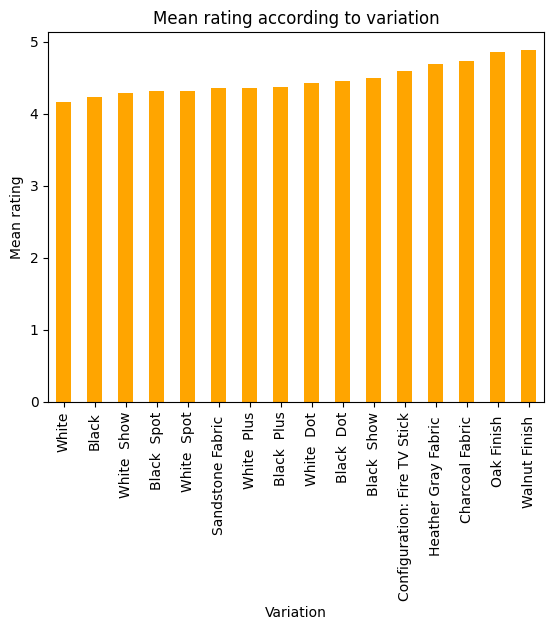

In [83]:
# variation rating mean value

data.groupby('variation')['rating'].mean().sort_values().plot.bar(color="orange")
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

## Analyzing 'verified_reviews' column
This column contains the textual review given by the user for a variation for the product.

In [84]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

##### Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

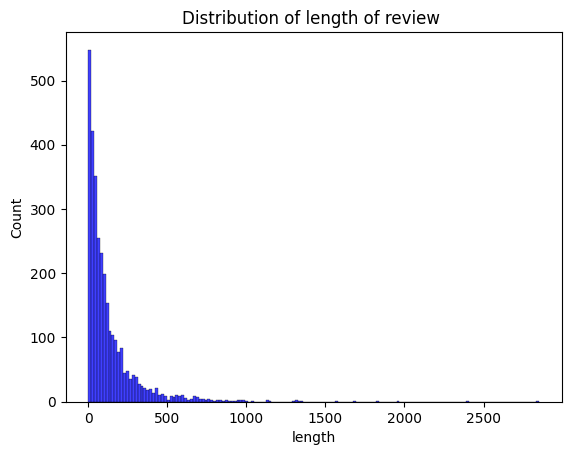

In [88]:
data['length'].count()
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

##### Length analysis when feedback is 0 (negative)

shorter length feedback are more negative
legth from 0 to 750 comes under negative 

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

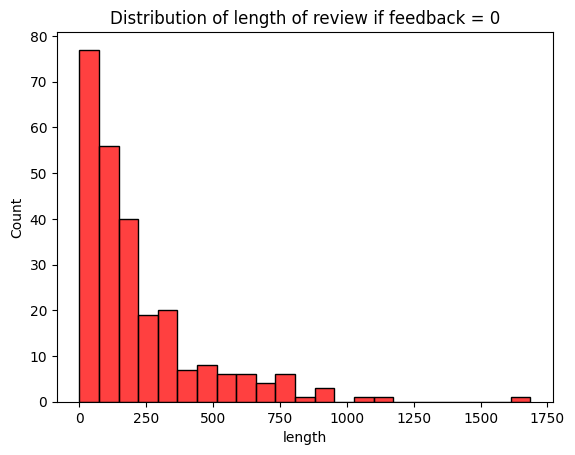

In [90]:
sns.histplot(data[data['feedback'] == 0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

##### Length analysis when feedback is 1 (positive)

shorter length feedback are more positive
mostly they are < 500 are positive

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

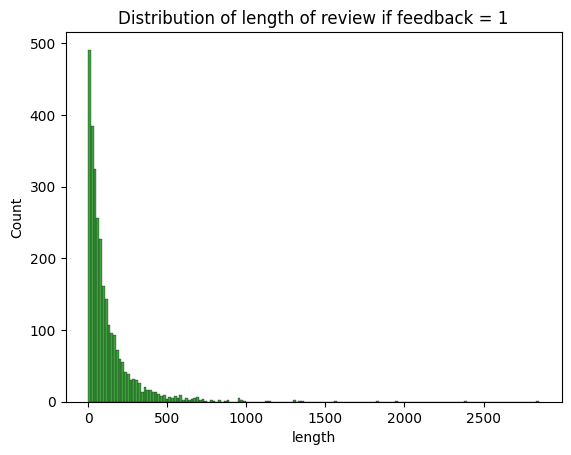

In [92]:
sns.histplot(data[data['feedback'] == 1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

##### Lengthwise mean rating

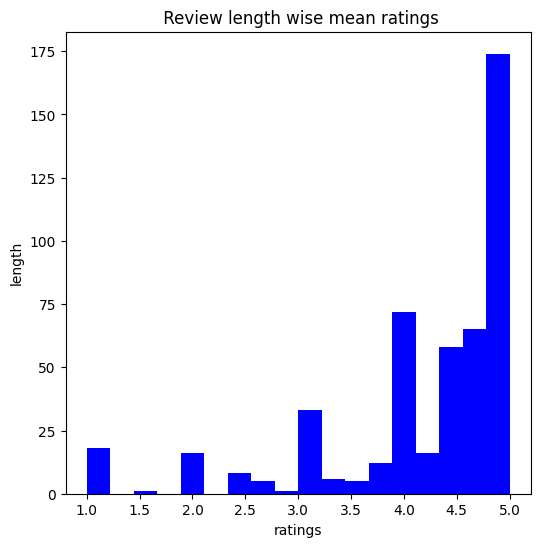

In [103]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(6, 6), bins = 18)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

lengthy feedbacks have more ratings

## CountVectorizer and fit_transform Explanation

This document explains how to use `CountVectorizer` from the `scikit-learn` library to process text data.

- ***CountVectorizer***: This is a class in scikit-learn used for converting a collection of text documents to a matrix of token counts.

### This method does two things:

- **fit**: Learns the vocabulary from the `data.verified_reviews`. It finds all the unique words in the reviews, excluding the stop words.
- **transform**: Transforms the text data into a matrix of token counts. Each row in this matrix corresponds to a review, and each column corresponds to a word in the vocabulary. The values in the matrix indicate the count of each word in each review.


In [104]:
#all the tokens exculding the stopwords
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

In [105]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

In [106]:
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

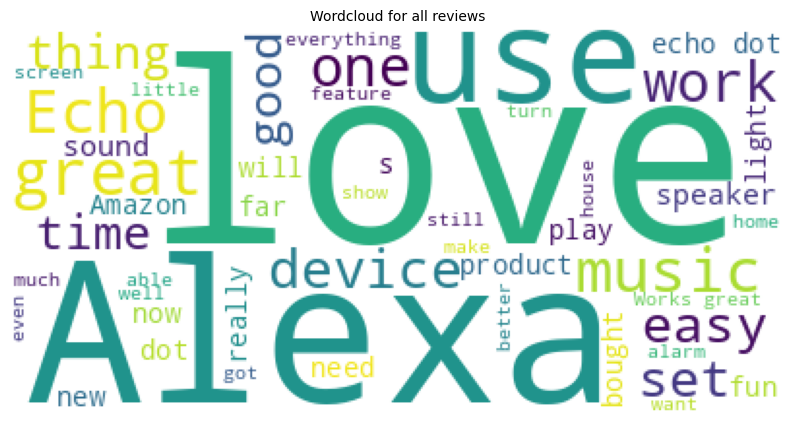

In [108]:
# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

##### Lets find the unique words in each feedback category

In [123]:

# Combine all reviews for each feedback category and splitting them into individual words

#splitting the negative and posiitve reviews

negative_reviews = "".join(data[data['feedback']==0]['verified_reviews'])
negative_reviews = negative_reviews.lower().split()


positive_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
positive_reviews = positive_reviews.lower().split()


In [124]:
#Finding words from reviews which are present in that feedback category only
#slect unique words that present only in negative and positive

unique_negative = [x for x in negative_reviews if x not in positive_reviews]
unique_negative = " ".join(unique_negative)


unique_positive = [x for x in positive_reviews if x not in negative_reviews]
unique_positive = " ".join(unique_positive)




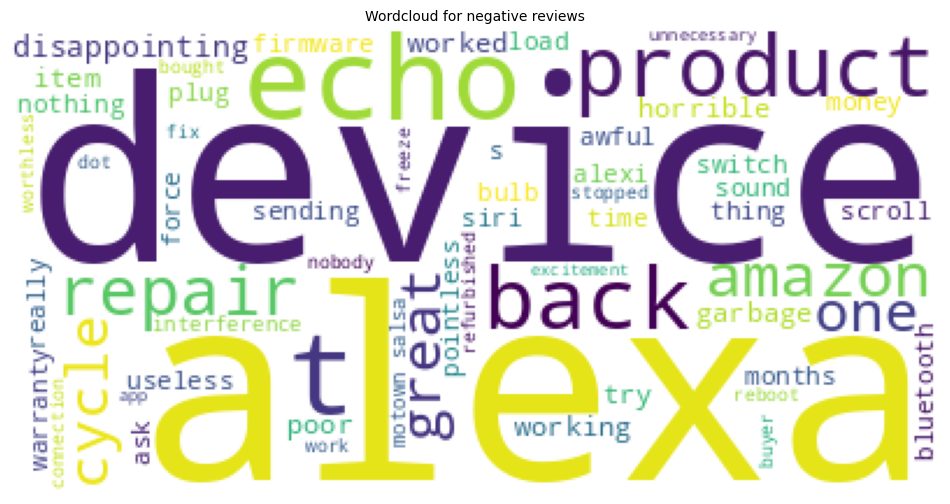

In [133]:
wc = WordCloud(background_color='white', max_words=60)

# Generate and plot wordcloud
plt.figure(figsize=(12,12))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

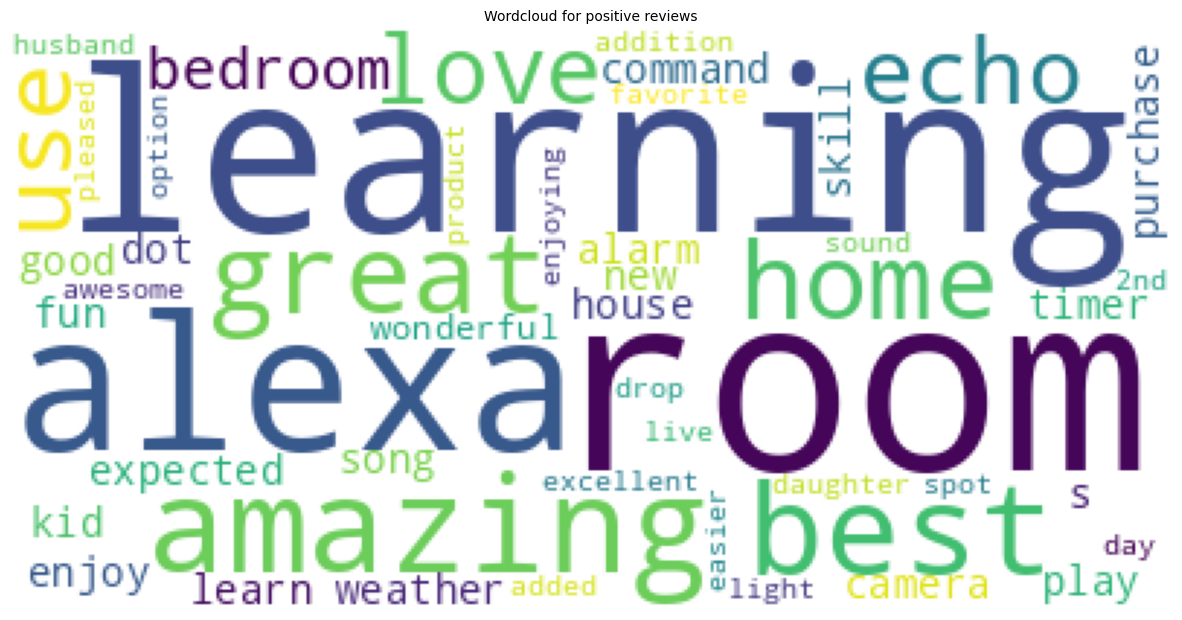

In [135]:

wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(15,15))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()